# Geo Economic Clustering
Eddy Tovar
## Task: 
Classify all countries in the world in 10 different groups according to the distance between them and their GDP (Gross Domestic Product) per capita. 

In [1]:
#! pip install haversine

#!pip install pandas-datareader
#https://pandas-datareader.readthedocs.io/en/latest/readers/world-bank.html

#!pip install kneed

#! pip install geopandas
#! pip install descartes

We will need to import some libraries:  
- pandas_datareader: This one in order to get data from World Bank open Data directly, instead of downloading a csv
- geopandas: Plotting groups in World Map

In [2]:
#import lybraries
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

#import data reader to get data
import pandas_datareader.wb as wb

#import haversine
from haversine import haversine

#Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#import geopandas for plotting
import geopandas as gpd
from descartes import PolygonPatch

In [3]:
wb.search('gdp').head()

,id,name,unit,source,sourceNote,sourceOrganization,topics
675,5.51.01.10.gdp,Per capita GDP growth,,Statistical Capacity Indicators,GDP per capita is the sum of gross value added...,b'World Development Indicator (WDI) databank. ...,
677,6.0.GDP_current,GDP (current $),,LAC Equity Lab,GDP is the sum of gross value added by all res...,b'World Development Indicators (World Bank)',Economy & Growth
678,6.0.GDP_growth,GDP growth (annual %),,LAC Equity Lab,Annual percentage growth rate of GDP at market...,b'World Development Indicators (World Bank)',Economy & Growth
679,6.0.GDP_usd,GDP (constant 2005 $),,LAC Equity Lab,GDP is the sum of gross value added by all res...,b'World Development Indicators (World Bank)',Economy & Growth
680,6.0.GDPpc_constant,"GDP per capita, PPP (constant 2011 internation...",,LAC Equity Lab,GDP per capita based on purchasing power parit...,b'World Development Indicators (World Bank)',Economy & Growth


## Get Data
The data is collected using datareader and passing the desired IDs.  
The IDs can be found in https://data.worldbank.org/indicator or using function search() above.

• 'NY.GDP.MKTP.CD' --> Total GDP | 'NY.GDP.PCAP.CD' --> GDP per capita


In [4]:
#Reading data
gdp_data = wb.WorldBankReader(symbols=['NY.GDP.MKTP.CD', 'NY.GDP.PCAP.CD'], countries='all')

In [5]:
#Get data frame
gdp_df = gdp_data.read()
gdp_df.head()

NY.GDP.MKTP.CD  NY.GDP.PCAP.CD
country    year                                
Arab World 2020             NaN             NaN
           2019    2.815410e+12     6580.056257
           2018    2.772025e+12     6603.351190
           2017    2.513494e+12     6102.211067
           2016    2.463434e+12     6097.239025

In [6]:
#Rename columns and reset index
gdp_df.columns = ['gdp', 'gdp_pc']
gdp_df_reind = gdp_df.reset_index()

Used only GDP from 2019, but it could be used last's years mean or other parameter 
in dependence with business requirements

In [7]:
#pick only 2019 and reset index
gdp_df_final = gdp_df_reind[gdp_df_reind['year']=='2019'].dropna()
gdp_df_final.reset_index(inplace=True, drop=True)
gdp_df_final.drop(['year'], axis=1, inplace=True)
gdp_df_final.head()

,country,gdp,gdp_pc
0,Arab World,2.815410e+12,6580.056257
1,Caribbean small states,7.629037e+10,10307.586281
2,Central Europe and the Baltics,1.656929e+12,16184.332009
3,Early-demographic dividend,1.198157e+13,3641.494281
4,East Asia & Pacific,2.697981e+13,11526.736486


Let's get countries Coordinate Geometry with the function get_countries()

In [8]:
geo_df = wb.get_countries()[['iso3c', 'name', 'latitude', 'longitude']]
geo_df

,iso3c,name,latitude,longitude
0,ABW,Aruba,12.51670,-70.0167
1,AFG,Afghanistan,34.52280,69.1761
2,AFR,Africa,NaN,NaN
3,AGO,Angola,-8.81155,13.2420
4,ALB,Albania,41.33170,19.8172
...,...,...,...,...
299,XZN,Sub-Saharan Africa excluding South Africa and ...,NaN,NaN
300,YEM,"Yemen, Rep.",15.35200,44.2075
301,ZAF,South Africa,-25.74600,28.1871
302,ZMB,Zambia,-15.39820,28.2937


Now merge the obtained geometric df with the gdp one

In [9]:
#change columns names and merge
geo_df.columns = ['iso_a3', 'country', 'lat', 'lng']

merged_df = pd.merge(
    gdp_df_final,
    geo_df,
    how = 'inner',
    on = 'country'
).dropna().reset_index(drop=True)

merged_df[40:50]

,country,gdp,gdp_pc,iso_a3,lat,lng
40,Cote d'Ivoire,5.879221e+10,2286.162777,CIV,5.332000,-4.0305
41,Croatia,6.041555e+10,14853.239837,HRV,45.806900,15.9614
42,Cyprus,2.456465e+10,27858.370996,CYP,35.167600,33.3736
43,Czech Republic,2.464892e+11,23101.777705,CZE,50.087800,14.4205
44,Denmark,3.480780e+11,59822.092961,DNK,55.676300,12.5681
45,Djibouti,3.318716e+09,3408.846254,DJI,11.580600,43.1425
46,Dominica,5.960333e+08,8300.375074,DMA,15.297600,-61.3900
47,Dominican Republic,8.894130e+10,8282.116222,DOM,18.479000,-69.8908
48,Ecuador,1.074357e+11,6183.823825,ECU,-0.229498,-78.5243
49,"Egypt, Arab Rep.",3.031751e+11,3020.031350,EGY,30.098200,31.2461


## Let's standarize country names
Getting the naturalearth dataset from geopandas we will:
- use better country names  
- get contours of countries in order to plotting them

In [10]:
#Correct names
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

final_df = pd.merge(
    merged_df,
    world[['iso_a3', 'name']],
    how = 'inner',
    on = 'iso_a3'
)

#drop bad country names column
final_df.drop(['country'], axis=1, inplace=True)
final_df.rename(columns={'name': 'country'}, inplace=True)
#reordering columns
final_df = final_df[['iso_a3', 'country', 'gdp_pc', 'gdp', 'lat', 'lng']]
final_df[40:50]

,iso_a3,country,gdp_pc,gdp,lat,lng
40,DOM,Dominican Rep.,8282.116222,8.894130e+10,18.479000,-69.8908
41,ECU,Ecuador,6183.823825,1.074357e+11,-0.229498,-78.5243
42,EGY,Egypt,3020.031350,3.031751e+11,30.098200,31.2461
43,SLV,El Salvador,4187.250031,2.702264e+10,13.703400,-89.2073
44,GNQ,Eq. Guinea,8131.923888,1.102677e+10,3.752300,8.7741
45,EST,Estonia,23659.872290,3.138695e+10,59.439200,24.7586
46,SWZ,eSwatini,3837.026994,4.405406e+09,-26.522500,31.4659
47,ETH,Ethiopia,857.501351,9.610766e+10,9.022740,38.7468
48,FJI,Fiji,6220.046421,5.535549e+09,-18.114900,178.3990
49,FIN,Finland,48685.853987,2.687612e+11,60.160800,24.9525


Let's plot the top 20 GDP Per capita countries

&lt;matplotlib.axes._subplots.AxesSubplot at 0x14aa3320520&gt;

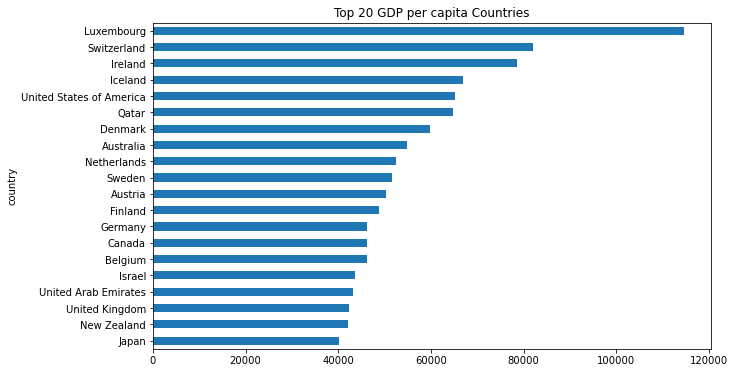

In [11]:
final_df[['country', 'gdp_pc']].sort_values(by='gdp_pc', ascending=False)[:20].sort_values(by='gdp_pc').plot(
    kind = 'barh',
    x = 'country',
    y= 'gdp_pc',
    title = 'Top 20 GDP per capita Countries',
    legend = False,
    figsize = (10, 6)
)

## Haversine

Using haversine library to create a dataframe with a matrix of countries' distances

In [12]:
#Creating new column 'geom'
final_df['geom'] = list(final_df[['lat', 'lng']].itertuples(index=False, name=None))
final_df.head()

,iso_a3,country,gdp_pc,gdp,lat,lng,geom
0,AFG,Afghanistan,502.115487,1.910135e+10,34.52280,69.17610,"(34.5228, 69.1761)"
1,ALB,Albania,5352.857411,1.527808e+10,41.33170,19.81720,"(41.3317, 19.8172)"
2,DZA,Algeria,3948.343279,1.699882e+11,36.73970,3.05097,"(36.7397, 3.05097)"
3,AGO,Angola,2973.591160,9.463542e+10,-8.81155,13.24200,"(-8.81155, 13.242)"
4,ARG,Argentina,10006.148974,4.496634e+11,-34.61180,-58.41730,"(-34.6118, -58.4173)"


In [13]:
#creating new df with distances matrix
dist_df = final_df['country'].to_frame()
#creating matrix
for coun in final_df.country:
    act_geo = final_df['geom'][final_df['country'] == coun].iloc[0]
    dist_df[coun] = final_df['geom'].apply(lambda x: haversine(act_geo, x))
#set index
dist_df.set_index('country', inplace=True)
dist_df.head()

,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,...,Ukraine,United Arab Emirates,United Kingdom,United States of America,Uruguay,Uzbekistan,Vanuatu,Vietnam,Zambia,Zimbabwe
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,4335.759348,5857.996337,7598.080170,15273.354886,2260.614600,11355.581565,4560.676655,1817.917858,12507.060981,...,3575.966386,1813.273544,5707.875995,11142.137819,15075.240932,754.213399,11931.425137,3879.591872,7033.284086,7079.409605
Albania,4335.759348,0.000000,1532.472299,5616.083647,11611.533654,2077.162753,15604.674041,812.370151,2518.931527,8756.799322,...,1306.049532,3694.930144,1891.288239,7763.972118,11470.408316,4071.830219,16034.265281,8162.637755,6368.160133,6680.060719
Algeria,5857.996337,1532.472299,0.000000,5175.638782,10165.257005,3597.503085,16975.586640,1675.669628,4045.368281,7561.254683,...,2661.002208,5034.754058,1660.361251,6796.272681,10038.359633,5602.807622,17456.539695,9695.086370,6373.392826,6742.848614
Angola,7598.080170,5616.083647,5175.638782,0.000000,7777.475969,6322.088260,13275.159526,6349.131918,6637.371766,10479.287946,...,6798.064264,5795.679326,6827.956334,10644.770822,7565.380851,7974.600383,15989.131092,10623.244971,1791.752437,2171.481799
Argentina,15273.354886,11611.533654,10165.257005,7777.475969,0.000000,13395.225142,11733.465730,11814.110890,13832.699705,6929.372367,...,12826.258852,13532.371188,11129.841384,8394.561393,216.954805,15438.488738,12382.111906,17854.936458,8748.456257,8848.126880


# Clustering
## Approach 1:  
- Lets apply Kmeans to the two main features, GDP per capita and distance in order to get 10 cluster

## Approach 2:  #TODO
- Applying dimensionality reduction to distance matrix in order to give more weight to the GDP-pc.

In [14]:
#drop unnecesary columns
clean_df = final_df.drop(['gdp', 'lat', 'lng', 'geom', 'iso_a3' ], axis=1).set_index('country')
#concat distance matrix
df_to_model = pd.concat([clean_df, dist_df], axis=1)
df_to_model.head()

,gdp_pc,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,...,Ukraine,United Arab Emirates,United Kingdom,United States of America,Uruguay,Uzbekistan,Vanuatu,Vietnam,Zambia,Zimbabwe
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,502.115487,0.000000,4335.759348,5857.996337,7598.080170,15273.354886,2260.614600,11355.581565,4560.676655,1817.917858,...,3575.966386,1813.273544,5707.875995,11142.137819,15075.240932,754.213399,11931.425137,3879.591872,7033.284086,7079.409605
Albania,5352.857411,4335.759348,0.000000,1532.472299,5616.083647,11611.533654,2077.162753,15604.674041,812.370151,2518.931527,...,1306.049532,3694.930144,1891.288239,7763.972118,11470.408316,4071.830219,16034.265281,8162.637755,6368.160133,6680.060719
Algeria,3948.343279,5857.996337,1532.472299,0.000000,5175.638782,10165.257005,3597.503085,16975.586640,1675.669628,4045.368281,...,2661.002208,5034.754058,1660.361251,6796.272681,10038.359633,5602.807622,17456.539695,9695.086370,6373.392826,6742.848614
Angola,2973.591160,7598.080170,5616.083647,5175.638782,0.000000,7777.475969,6322.088260,13275.159526,6349.131918,6637.371766,...,6798.064264,5795.679326,6827.956334,10644.770822,7565.380851,7974.600383,15989.131092,10623.244971,1791.752437,2171.481799
Argentina,10006.148974,15273.354886,11611.533654,10165.257005,7777.475969,0.000000,13395.225142,11733.465730,11814.110890,13832.699705,...,12826.258852,13532.371188,11129.841384,8394.561393,216.954805,15438.488738,12382.111906,17854.936458,8748.456257,8848.126880


&lt;matplotlib.axes._subplots.AxesSubplot at 0x14aa5079a60&gt;

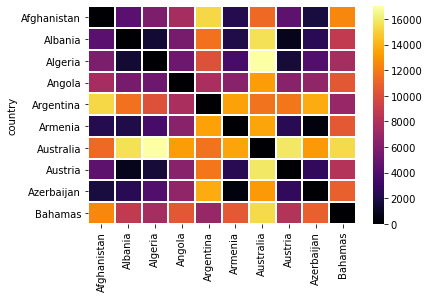

In [15]:
plot = df_to_model.drop(['gdp_pc'], axis=1)

sns.heatmap(
    plot.iloc[0:10, 0:10],
    #figsize=(10,10),
    cmap='inferno',
    linewidth=1
)

# Kmeans
# Approach 1:

In [16]:
# Scaling
features_df = df_to_model
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

In [17]:
 kmeans = KMeans(
     init="random",
     n_clusters=10,
     max_iter=300,
     random_state=42
 )

 kmeans.fit(scaled_features)

KMeans(init=&#39;random&#39;, n_clusters=10, random_state=42)

In [18]:
kmeans.labels_

array([8, 9, 9, 3, 1, 5, 6, 9, 5, 0, 4, 9, 9, 7, 2, 1, 9, 3, 1, 4, 9, 2,
       3, 4, 2, 0, 3, 2, 1, 4, 7, 3, 3, 7, 2, 9, 5, 9, 9, 5, 0, 7, 5, 7,
       2, 9, 3, 5, 6, 9, 2, 2, 5, 9, 2, 9, 7, 2, 2, 0, 0, 7, 9, 9, 8, 4,
       5, 9, 5, 9, 0, 4, 5, 8, 3, 4, 5, 8, 4, 9, 5, 3, 2, 9, 9, 9, 3, 3,
       4, 2, 2, 7, 9, 4, 9, 9, 3, 4, 3, 8, 9, 6, 7, 2, 2, 9, 8, 8, 7, 6,
       1, 1, 4, 9, 9, 0, 5, 9, 9, 3, 5, 2, 9, 2, 9, 9, 6, 3, 9, 4, 5, 0,
       9, 9, 8, 3, 4, 4, 2, 0, 9, 5, 3, 9, 5, 9, 0, 1, 8, 6, 4, 3, 3])

## Creating Columns

In [19]:
#select columns
df_to_order = final_df.iloc[:,0:4].set_index('country')

#add group label
df_to_order['group_label'] = kmeans.labels_

#group’s average GDP per capita
group_means = df_to_order.groupby('group_label')['gdp_pc'].mean()
df_to_order['gdpc_mean'] = df_to_order['group_label'].apply(lambda x: group_means[x])

#reordering columns
df_to_order = df_to_order[['iso_a3', 'group_label', 'gdpc_mean', 'gdp_pc', 'gdp']]

df_to_order.head()

,iso_a3,group_label,gdpc_mean,gdp_pc,gdp
country,,,,,
Afghanistan,AFG,8,3785.801510,502.115487,1.910135e+10
Albania,ALB,9,28059.256725,5352.857411,1.527808e+10
Algeria,DZA,9,28059.256725,3948.343279,1.699882e+11
Angola,AGO,3,2045.883865,2973.591160,9.463542e+10
Argentina,ARG,1,9393.497108,10006.148974,4.496634e+11


# Sorting  
1.
group’s average GDP per capita 'gdpc_mean'   
2.
country’s total GDP 'gdp'

In [20]:
ordered_df = df_to_order.sort_values(by=['gdpc_mean', 'gdp'], ascending = False)
ordered_df

,iso_a3,group_label,gdpc_mean,gdp_pc,gdp
country,,,,,
Germany,DEU,9,28059.256725,46258.878290,3.845630e+12
United Kingdom,GBR,9,28059.256725,42300.267126,2.827113e+12
Italy,ITA,9,28059.256725,33189.565799,2.001244e+12
Russia,RUS,9,28059.256725,11584.995383,1.699877e+12
Spain,ESP,9,28059.256725,29613.671138,1.394116e+12
...,...,...,...,...,...
Togo,TGO,2,1873.912955,675.542213,5.459979e+09
Sierra Leone,SLE,2,1873.912955,504.462543,3.941474e+09
Liberia,LBR,2,1873.912955,621.892954,3.070518e+09


# Map Plotting
In order to understand the groups better, Let's plot countries and group on the world map

In [21]:
import matplotlib.patches as mpatches
def plotCountryPatch(axes, country_name, fcolor):
    # plot a country on the provided axes
    country = world[world.name == country_name]
    countrygm = country.__geo_interface__['features']  # geopandas's geo_interface
    country0 = {'type': countrygm[0]['geometry']['type'], \
              'coordinates': countrygm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( country0, fc=fcolor, ec="black", zorder=2))

def plot_groups(df):
    # plot the whole world
    ax2 = world.plot(figsize=(18, 12), edgecolor=u'gray', color='white', legend=True)

    # then plot countries
    colors = {0: 'Wheat', 1: 'green', 2: 'blue', 3: 'orange', 4: 'Teal', 5: 'yellow', 6: 'Fuchsia', 7: 'brown', 8: 'Lime', 9: 'Crimson'}

    #legend
    LegendElement = [mpatches.Patch(color=color, label=group) for group, color in colors.items()]
    
    ax2.legend(handles = LegendElement, loc='mid left')

    for name, color in zip(df.index, df.group_label):
        plotCountryPatch(ax2, name, colors[color])

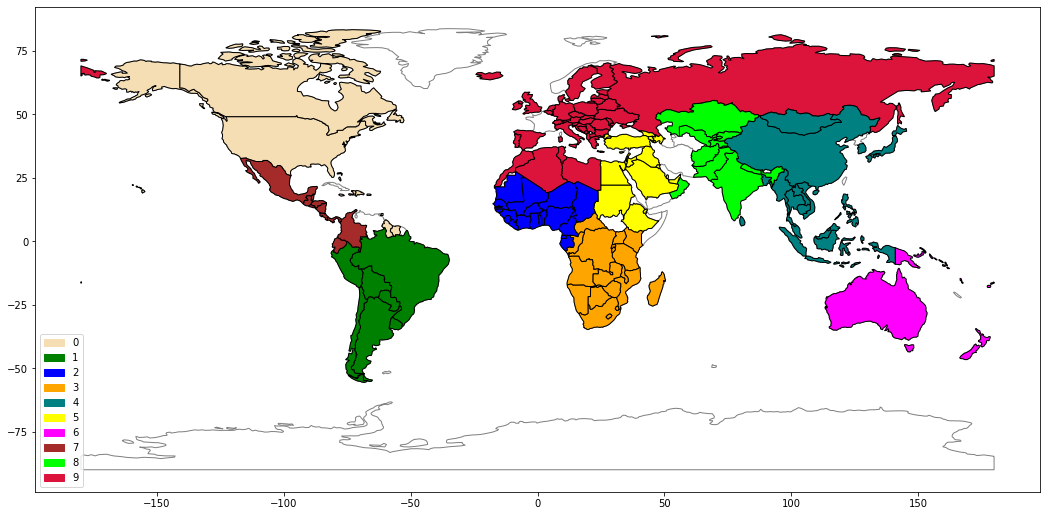

In [22]:
plot_groups(ordered_df)

# Kmeans
# Approach 2:

In [74]:
scaled_gdpc = scaled_features[:, 0].reshape(153,1)
scaled_dist = scaled_features[:, 1:]

#PCA for dimensionality reduction
pca = PCA(n_components=5, random_state=42).fit(scaled_dist)
dist_reduce = pca.transform(scaled_dist)

print('original number of features -->', dist_df.shape)
print('reduced number of features -->', dist_reduce.shape)

original number of features --&gt; (153, 153)
reduced number of features --&gt; (153, 5)


In [75]:
array_to_model = np.concatenate((scaled_gdpc,dist_reduce),axis=1)

second_kmeans = KMeans(
    init="random",
    n_clusters=10,
    max_iter=300,
    random_state=42
 )

second_kmeans.fit(array_to_model)

KMeans(init=&#39;random&#39;, n_clusters=10, random_state=42)

In [76]:
kmeans.labels_ == second_kmeans.labels_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

After the dimensionality reduction, only 4 labels have changed.

In [77]:
second_df = df_to_order.copy()
second_df['group_label'] = second_kmeans.labels_

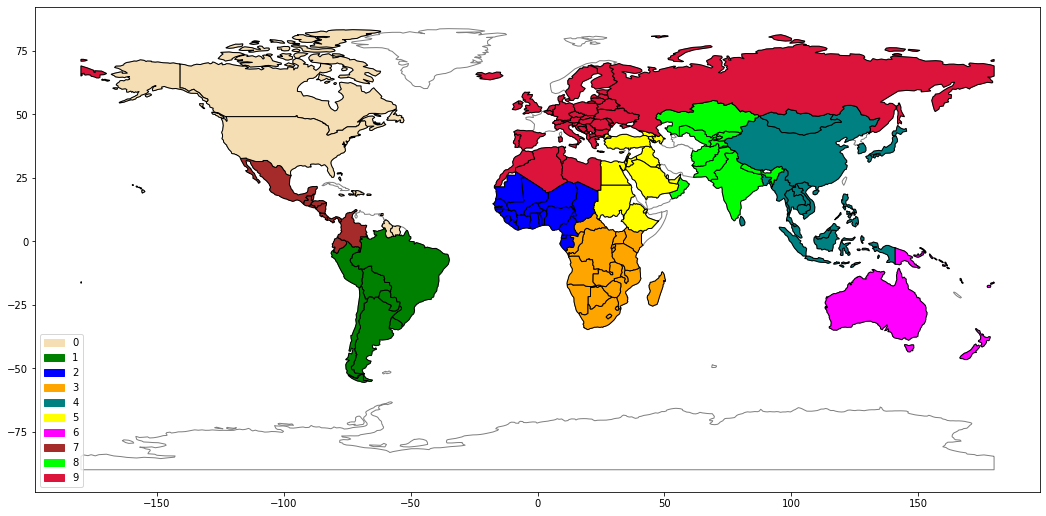

In [78]:
plot_groups(second_df)

## Cumulative GDP fraction
- cumulative GDP fraction (0 to 1) within the group
- The cumulative GDP fraction within each group should be calculated with this order in mind (highest
total GDP first).

In [79]:
#Get GDP sum of each group and assign it to a coulumn
gdp_sum = ordered_df.groupby('group_label')['gdp'].sum()
ordered_df['sum'] = ordered_df['group_label'].apply(lambda x: gdp_sum[x])

#Get the GDP fraction of each country in the group and assaign it to a column
ordered_df['fraction'] = ordered_df['gdp']/ordered_df['sum']

ordered_df.head()

,iso_a3,group_label,gdpc_mean,gdp_pc,gdp,sum,fraction
country,,,,,,,
Germany,DEU,9,28059.256725,46258.878290,3.845630e+12,1.880552e+13,0.204495
United Kingdom,GBR,9,28059.256725,42300.267126,2.827113e+12,1.880552e+13,0.150334
Italy,ITA,9,28059.256725,33189.565799,2.001244e+12,1.880552e+13,0.106418
Russia,RUS,9,28059.256725,11584.995383,1.699877e+12,1.880552e+13,0.090392
Spain,ESP,9,28059.256725,29613.671138,1.394116e+12,1.880552e+13,0.074133


In [80]:
# fraction cumsum of each group
# creating a list with all cumulative sums of all groups
cum_sum = []
for x in ordered_df['group_label'].unique(): #unique labels
    cum_group = ordered_df[ordered_df['group_label']== x]['fraction'].cumsum() 
    cum_sum = cum_sum + cum_group.values.tolist()

In [84]:
#Create Column and drop unused ones
ordered_df['cum_sum'] = cum_sum
final_answer = ordered_df.drop(['sum', 'fraction'], axis=1)
final_answer

KeyError: &quot;[&#39;sum&#39; &#39;fraction&#39;] not found in axis&quot;

In [82]:
final_answer.to_csv('output/geo_economic.csv')